In [20]:
import numpy as np
import itertools
import pandas as pd
from scipy.stats import multivariate_normal, norm
import gurobipy as gp
from gurobipy import GRB
from IPython.display import display, Math
from gurobipy import GRB, quicksum
import matplotlib.pyplot as plt
import seaborn as sns

##### 2.1 Problem Setup and Weighting Framework

Calculate the true factorial effect of both main effect and interaction effect in the simulation

In [ ]:
np.random.seed(42)
# Set up the parameters
K = 3  # Number of binary factors
Q = 2 ** K  # Number of possible treatment combinations
N = 1000  # Number of subjects

# Generate all possible treatment combinations
treatment_combinations = np.array(list(itertools.product([-1, 1], repeat=K)))

# Simulate covariates X (D-dimensional, here D=3 for simplicity)
D = 3
X = np.random.normal(0, 1, size=(N, D))

# Simulate potential outcomes for each individual and each treatment combination
# Assume potential outcomes depend on treatment and covariates linearly
beta_treatment = np.random.randn(Q)  # Random effect size for each treatment combination
beta_covariate = np.random.randn(D)  # Effect size for covariates

# For each subject, generate potential outcomes
Y_potential = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        Y_potential[i, q] = beta_treatment[q] + X[i].dot(beta_covariate) + np.random.normal(0, 1)

# Assign each individual a random treatment from the possible combinations
Z_indices = np.random.choice(Q, size=N)  # Random treatment assignment
Y_observed = np.array([Y_potential[i, Z_indices[i]] for i in range(N)])  # Observed outcome

# Estimate main effects
# Contrast vector for each factor
# arms = list(itertools.product([0,1], repeat=K))
# g_factor1 = []
# for z in arms:
#     if z[0] == 1:
#         g_factor1.append( +1.0 )
#     else:
#         g_factor1.append( -1.0 )
# g_factor1 = np.array(g_factor1)

main_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    E_Y = np.array([np.mean(Y_observed[Z_indices == q]) if np.any(Z_indices == q) else 0 for q in range(Q)])
    tau_k = (1 / (2 ** (K - 1))) * g_k.T @ E_Y
    main_effects.append(tau_k)

# Estimate interaction effects between two factors
interaction_effects = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2
    tau_k1k2 = (1 / (2 ** (K - 1))) * g_interaction @ E_Y
    interaction_effects[(k1, k2)] = tau_k1k2

# Present results
results = {
    "Main Effects": main_effects,
    "Interaction Effects": interaction_effects
}

# Convert results to DataFrame for display
main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Estimated Main Effect': main_effects
})

interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects.items()],
    columns=['Interaction', 'Estimated Effect']
)

# Display the DataFrames using standard methods
print("Main Effects Estimates:\n")
print(main_effects_df)

print("\nInteraction Effects Estimates:\n")
print(interaction_effects_df)


Main Effects Estimates:

  Factor  Estimated Main Effect
0    z_1              -0.161658
1    z_2               1.055239
2    z_3              -0.132745

Interaction Effects Estimates:

  Interaction  Estimated Effect
0   z_1 & z_2         -1.158903
1   z_1 & z_3         -1.797397
2   z_2 & z_3          0.317097


##### 2.2 Weighting for Observational Factorial Studies

Calculate the estimated factorial effect tau_hat in observational factorial study by applying a weighting function

In [131]:

# Simulate f(X) and f_z(X) for weighting function
# Assume f(X) is standard normal and f_z(X) shifts mean for treatment groups
f_X = norm.pdf(X)
f_z = np.zeros(N)
for i in range(N):
    z_idx = Z_indices[i]
    treatment_effect = treatment_combinations[z_idx]
    shifted_mean = treatment_effect * 0.5  # Shifted by treatment effect
    f_z[i] = np.prod(norm.pdf(X[i], loc=shifted_mean, scale=1))

# Weighting function w_z(X) = f(X) / f_z(X)
w_z = np.prod(f_X, axis=1) / f_z
w_i = N * w_z / (2 ** (K - 1) * np.bincount(Z_indices, minlength=Q)[Z_indices])

# Calculate the weighting estimator for factorial effects
weighted_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    g_k_pos = np.maximum(g_k, 0)
    g_k_neg = np.maximum(-g_k, 0)

    # A_iK^+ and A_iK^-
    A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    # Weighted estimators for tau_K^+ and tau_K^-
    tau_k_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_k_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    # Combine to get the weighted factorial effect
    tau_k_weighted = tau_k_pos - tau_k_neg
    weighted_effects.append(tau_k_weighted)

# Interaction effects using the weighting estimator
interaction_effects_weighted = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2

    g_interaction_pos = np.maximum(g_interaction, 0)
    g_interaction_neg = np.maximum(-g_interaction, 0)

    A_iK_pos = np.array([np.sum([g_interaction_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    tau_inter_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_inter_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    tau_inter_weighted = tau_inter_pos - tau_inter_neg
    interaction_effects_weighted[(k1, k2)] = tau_inter_weighted

# Prepare results
weighted_main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Weighted Effect': weighted_effects
})

weighted_interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects_weighted.items()],
    columns=['Interaction', 'Weighted Effect']
)

# Display results
print("Weighted Main Effects Using Weighting Estimator:\n", weighted_main_effects_df)
print("\nWeighted Interaction Effects Using Weighting Estimator:\n", weighted_interaction_effects_df)


Weighted Main Effects Using Weighting Estimator:
   Factor  Weighted Effect
0    z_1        -2.987851
1    z_2         4.016794
2    z_3         0.297760

Weighted Interaction Effects Using Weighting Estimator:
   Interaction  Weighted Effect
0   z_1 & z_2        -1.370218
1   z_1 & z_3        -3.425903
2   z_2 & z_3         0.728277


#### 3.1 Weighting for Estimating a Single Factorial Effect 

##### 3.1.1 General Additive Outcome Model

The model assumes outcomes are affected by both covariates and factorial interactions.

The weighting balances both: Covariates across treatment assignments and Higher-order interactions that can bias the factorial effect estimation.

In [132]:

# Parameters
K = 3  # Number of binary factors
Q = 2 ** K  # Number of treatment combinations
N = 1000  # Number of individuals

# Generate treatment combinations
treatment_combinations = np.array(list(itertools.product([-1, 1], repeat=K)))

# Simulate covariates X (D-dimensional)
D = 3
X = np.random.normal(0, 1, size=(N, D))

# Simulate potential outcomes using a general additive model
S = 3  # Number of basis functions
alpha = np.random.randn(S)
beta = np.random.randn(Q)

# Define basis functions h_s(X) = X^s (simple polynomial basis)
def h_s(X, s):
    return X ** (s + 1)

# Compute mu(X) and nu(z)
mu_X = np.sum([alpha[s] * h_s(X, s).sum(axis=1) for s in range(S)], axis=0)
nu_z = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        z = treatment_combinations[q]
        nu_z[i, q] = beta[q] * np.prod(z)

# Simulate potential outcomes with reshaping for broadcasting
Y_potential = mu_X[:, np.newaxis] + nu_z + np.random.normal(0, 1, size=(N, Q))


# Random assignment of treatments
Z_indices = np.random.choice(Q, size=N)
Y_observed = np.array([Y_potential[i, Z_indices[i]] for i in range(N)])

# Simulate f(X) and f_z(X) for weighting
f_X = norm.pdf(X)
f_z = np.zeros(N)
for i in range(N):
    z_idx = Z_indices[i]
    treatment_effect = treatment_combinations[z_idx]
    shifted_mean = treatment_effect * 0.5
    f_z[i] = np.prod(norm.pdf(X[i], loc=shifted_mean, scale=1))

# Weighting function
w_z = np.prod(f_X, axis=1) / f_z
w_i = N * w_z / (2 ** (K - 1) * np.bincount(Z_indices, minlength=Q)[Z_indices])

# Calculate the new weighting estimator
weighted_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    g_k_pos = np.maximum(g_k, 0)
    g_k_neg = np.maximum(-g_k, 0)

    # A_iK^+ and A_iK^-
    A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    # Weighted estimators for tau_K^+ and tau_K^-
    tau_k_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_k_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    # Combine to get the weighted factorial effect
    tau_k_weighted = tau_k_pos - tau_k_neg
    weighted_effects.append(tau_k_weighted)

# Interaction effects using the new weighting estimator
interaction_effects_weighted = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2

    g_interaction_pos = np.maximum(g_interaction, 0)
    g_interaction_neg = np.maximum(-g_interaction, 0)

    A_iK_pos = np.array([np.sum([g_interaction_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    tau_inter_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_inter_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    tau_inter_weighted = tau_inter_pos - tau_inter_neg
    interaction_effects_weighted[(k1, k2)] = tau_inter_weighted

# Prepare results
weighted_main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Weighted Effect': weighted_effects
})

weighted_interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects_weighted.items()],
    columns=['Interaction', 'Weighted Effect']
)

# Display results
print("Weighted Main Effects Using New Weighting Estimator:\n", weighted_main_effects_df)
print("\nWeighted Interaction Effects Using New Weighting Estimator:\n", weighted_interaction_effects_df)


Weighted Main Effects Using New Weighting Estimator:
   Factor  Weighted Effect
0    z_1       -24.132946
1    z_2       -23.197599
2    z_3       -31.894444

Weighted Interaction Effects Using New Weighting Estimator:
   Interaction  Weighted Effect
0   z_1 & z_2       -12.284402
1   z_1 & z_3        -1.435613
2   z_2 & z_3       -12.994322


##### 3.1.2 Outcome Model with Treatment Effect Heterogeneity

In [133]:
# Parameters
K = 3  # Number of binary factors
Q = 2 ** K  # Number of treatment combinations
N = 1000  # Number of individuals

# Generate treatment combinations
treatment_combinations = np.array(list(itertools.product([-1, 1], repeat=K)))

# Simulate covariates X (D-dimensional)
D = 3
X = np.random.normal(0, 1, size=(N, D))

# Simulate potential outcomes using heterogeneous treatment effects
S = 3  # Number of basis functions
alpha = np.random.randn(S, Q)  # Different coefficients for each treatment
beta = np.random.randn(Q)

# Define basis functions h_s(X) = X^s (polynomial basis)
def h_s(X, s):
    return X ** (s + 1)

# Define heterogeneous basis functions q_sJ(X, z)
def q_sJ(X, z, s):
    return h_s(X, s) * np.prod(z)

# Compute mu(X, z) with heterogeneity
mu_XZ = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        z = treatment_combinations[q]
        mu_XZ[i, q] = sum([alpha[s, q] * h_s(X[i], s).sum() for s in range(S)])

# Simulate nu(z)
nu_z = np.zeros((N, Q))
for i in range(N):
    for q in range(Q):
        z = treatment_combinations[q]
        nu_z[i, q] = beta[q] * np.prod(z)

# Generate potential outcomes
Y_potential = mu_XZ + nu_z + np.random.normal(0, 1, size=(N, Q))

# Random assignment of treatments
Z_indices = np.random.choice(Q, size=N)
Y_observed = np.array([Y_potential[i, Z_indices[i]] for i in range(N)])

# Simulate f(X) and f_z(X) for weighting function
f_X = norm.pdf(X)
f_z = np.zeros(N)
for i in range(N):
    z_idx = Z_indices[i]
    treatment_effect = treatment_combinations[z_idx]
    shifted_mean = treatment_effect * 0.5
    f_z[i] = np.prod(norm.pdf(X[i], loc=shifted_mean, scale=1))

# Weighting function
w_z = np.prod(f_X, axis=1) / f_z
w_i = N * w_z / (2 ** (K - 1) * np.bincount(Z_indices, minlength=Q)[Z_indices])

# Calculate the weighting estimator with heterogeneity
weighted_effects = []
for k in range(K):
    g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])
    g_k_pos = np.maximum(g_k, 0)
    g_k_neg = np.maximum(-g_k, 0)

    # A_iK^+ and A_iK^-
    A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    # Weighted estimators for tau_K^+ and tau_K^-
    tau_k_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_k_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    # Combine to get the weighted factorial effect
    tau_k_weighted = tau_k_pos - tau_k_neg
    weighted_effects.append(tau_k_weighted)

# Interaction effects with heterogeneity
interaction_effects_weighted = {}
for k1, k2 in itertools.combinations(range(K), 2):
    g_k1 = np.array([1 if comb[k1] == 1 else -1 for comb in treatment_combinations])
    g_k2 = np.array([1 if comb[k2] == 1 else -1 for comb in treatment_combinations])
    g_interaction = g_k1 * g_k2

    g_interaction_pos = np.maximum(g_interaction, 0)
    g_interaction_neg = np.maximum(-g_interaction, 0)

    A_iK_pos = np.array([np.sum([g_interaction_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
    A_iK_neg = 1 - A_iK_pos

    tau_inter_pos = (1 / N) * np.sum(w_i * A_iK_pos * Y_observed)
    tau_inter_neg = (1 / N) * np.sum(w_i * A_iK_neg * Y_observed)

    tau_inter_weighted = tau_inter_pos - tau_inter_neg
    interaction_effects_weighted[(k1, k2)] = tau_inter_weighted

# Prepare results
weighted_main_effects_df = pd.DataFrame({
    'Factor': [f'z_{k+1}' for k in range(K)],
    'Weighted Effect': weighted_effects
})

weighted_interaction_effects_df = pd.DataFrame(
    [(f'z_{k1+1} & z_{k2+1}', effect) for (k1, k2), effect in interaction_effects_weighted.items()],
    columns=['Interaction', 'Weighted Effect']
)

# Display results
print("Weighted Main Effects with Heterogeneity:\n", weighted_main_effects_df)
print("\nWeighted Interaction Effects with Heterogeneity:\n", weighted_interaction_effects_df)


Weighted Main Effects with Heterogeneity:
   Factor  Weighted Effect
0    z_1         0.482502
1    z_2        -5.983616
2    z_3         6.097514

Weighted Interaction Effects with Heterogeneity:
   Interaction  Weighted Effect
0   z_1 & z_2        -1.208426
1   z_1 & z_3        -1.007165
2   z_2 & z_3         7.781101


#### Simulate the proposed weighting estimator using additive balance constraints under a general additive model. 
##### The proposed weighting estimator using balance constraints under the general additive model assumption (additive balance constraints) and covariate basis functions h𝑠(𝐗) = 𝑋𝑠, 𝑠 = 1, ... , 5, 

Wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on he balance constrains we need to optimize using gurobi to minimize the weighting wi. 

The balance constrains are: 

$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} h_s(\mathbf{X}_i) = \sum_{i=1}^{N} h_s(\mathbf{X}_i), \quad \text{for } \Omega = +, - \text{ and } s = 1, \dots, S,
$$

we also need to include the factors themselves and the non-negligible interactions as additional "covariates" for balancing such that

$$
\frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} \prod_{j \in J} Z_{ij} = \frac{1}{2^{K-1}} \sum_{z \in \mathcal{Z}} g_{\kappa z}^{\Omega} \prod_{j \in J} z_j,  \text{ for } \Omega = +,- \text{ and } J \in [K]_{K'}.
$$



After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $$\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$$ 

Then calculate the estimated weighted factorial effects tua_hat in the Section 2.2 where 


we need to assign a weight of $w_{Z_i}(\mathbf{X}_i)$ to the observed outcome of individual i, determined by the specific treatment combination they received.

Let $w_i = N w_{Z_i}(\mathbf{X}_i)/(2^{K-1} N_{Z_i})$ denote the normalized weights, and let


$$
A_{i\kappa}^{+} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{+} I(Z_i = z)
$$

$$
A_{i\kappa}^{-} = \sum_{z \in \mathcal{Z}} g_{\kappa z}^{-} I(Z_i = z) = 1 - A_{i\kappa}^{+} 
$$

denote whether individual i belongs to the positive or negative part of contrast $\mathbf{g}_\kappa$, respectively.


We estimate the factorial effect $\tau_\kappa$ with the weighting estimator:


$$
\hat{\tau}_\kappa = \hat{\tau}_\kappa^{+} - \hat{\tau}_\kappa^{-}, 
$$

$$
\text{where    }     \hat{\tau}_\kappa^{\Omega} = \frac{1}{N} \sum_{i=1}^{N} w_i A_{i\kappa}^{\Omega} Y_i^{\text{obs}}, \quad \text{for } \Omega = +, -.
$$

Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of (\hat\tau-\tau)^2.

In [36]:
np.random.seed(123)

# Step 1: Generate Xi from a multivariate normal distribution
def generate_covariates(N, mu, rho):
    K = len(mu)
    Sigma = rho * np.ones((K, K)) + (1 - rho) * np.eye(K)  # Covariance matrix
    X = multivariate_normal.rvs(mean=mu, cov=Sigma, size=N)
    return X

# Step 2: Generate 3 treatment assignments Zik based on logistic regression
def generate_treatment(X, betas):
    N = X.shape[0]
    K = len(betas)  # Number of factors
    Z = np.zeros((N, K))  # Initialize treatment matrix

    # Generate treatments independently for each factor
    for k in range(K):
        logits = X @ betas[k]  # Same logistic function applied for simplicity
        prob = 1 / (1 + np.exp(-logits))  # Probability for treatment assignment
        Z[:, k] = np.random.binomial(1, prob)  # Generate binary assignment for each factor

    return Z

# Step 3: Simulate potential outcomes Yi1, Yi2, Yi3
def simulate_outcomes(X, Z):
    N = X.shape[0]
    epsilon1 = np.random.normal(0, 1, N)
    epsilon2 = np.random.normal(0, 1, N)
    epsilon3 = np.random.normal(0, 1, N)

    # Simulate outcomes based on the paper's specifications
    Y1 = 2 * np.sum(X, axis=1) + np.sum(Z, axis=1) + epsilon1
    interaction_term = np.sum(X[:, :3] * Z, axis=1)  # Interaction with first 3 covariates
    Y2 = 2 * np.sum(X, axis=1) + interaction_term + epsilon2
    Y3 = np.sin(X[:, 0]) + np.cos(X[:, 1]) + (np.minimum(1, X[:, 0]) + X[:, 1]) * Z[:, 0] + np.sum(X[:, :2] * Z[:, 1:3], axis=1) + epsilon3

    return Y1, Y2, Y3

# Step 4: Optimize weights using Gurobi with variance minimization
def solve_weights_additive(X, Z, # data
                           # For main-effect k, we want:
                           # sum_i w_i A^+_{i,k} h_s(X_i) = sum_i h_s(X_i),
                           # sum_i w_i A^-_{i,k} h_s(X_i) = sum_i h_s(X_i),
                           # plus the factor-balance constraints:
                           # sum_i w_i A^+_{i,k} Z_i_j = ...
                           # BUT if only main effects, that is simpler:
                           # We'll do them for k in [1..K].
                           ):
    """
    Solves for w_i >= 0 to satisfy the "additive" balance constraints
    for all K main-effect contrasts simultaneously:
      sum_i w_i * A^+_{i,k} * X_i[d] = sum_i X_i[d],  for all d=1..D, k=1..K
      sum_i w_i * A^-_{i,k} * X_i[d] = sum_i X_i[d],  for all d=1..D, k=1..K
      sum_i w_i * A^+_{i,k}         = #units,        for each k
      sum_i w_i * A^-_{i,k]         = #units,        for each k
      ...
    plus we minimize sum_i w_i^2.
    Implementation note: we use a QP in Gurobi.
    """
    N = X.shape[0]

    # Build A^+_{i,k} and A^-_{i,k}
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    # (Alternatively we can code the full factorial g^+, but with only main effects we can do it simply.)
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Right-hand side for X-balance.  For each d in 1..D,
    # sum_i X_i[d]. We'll need that for each k in 1..K, plus and minus part.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  # turn off solver chatter

    # w_i variables
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # Objective: minimize sum_i w_i^2
    # We'll build a quadratic objective: sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # Now add constraints:
    # For each k in [0..K-1], for each d in [0..D-1]:
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    for k_ in range(K):
        for d_ in range(5):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # We also need factor-balance constraints themselves.
    # With only main effects, we need:
    # sum_i w_i * A^+_{i,k}  = (# of units), sum_i w_i*A^-_{i,k} = (# of units),
    # or equivalently the "treatment" sums. But in a fully "additive" approach
    # we can treat them as we did for the X's with h_s( X )=1 (the intercept).
    # So let's just do it by letting "d_=-1" stand for intercept:
    # That is sum_i w_i * A^+_{i,k} = sum_i 1 = N, etc.
    # We'll just directly code them:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)

    # Solve
    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

# Step 5: Calculate the true factorial main effects tau for each treatment factor
def calculate_tau(Y, Z, K):
    n_combinations = 2 ** K
    treatment_combinations = np.array([[int(x) for x in format(i, f'0{K}b')] for i in range(n_combinations)])
    Q = len(treatment_combinations)

    # Assign each individual to a treatment combination index
    Z_indices = np.array([int("".join(map(str, map(int, row))), 2) for row in Z.astype(int)])

    main_effects = []
    for k in range(K):  # For each treatment factor
        # Contrast vector for the kth factor
        g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])

        # Calculate mean outcomes for each treatment combination
        E_Y = np.array([np.mean(Y[Z_indices == q]) if np.any(Z_indices == q) else 0 for q in range(Q)])

        # Calculate tau_k for each factor
        tau_k = (1 / (2 ** (K - 1))) * g_k.T @ E_Y
        main_effects.append(tau_k)

    return np.array(main_effects)

# Step 6: Calculate estimated factorial effects tau_hat for each treatment factor with weights
def calculate_tau_hat(Y, weights, Z, K):
    N = len(Y)
    Q = 2 ** K  # Number of treatment combinations
    weighted_effects = []

    # Generate all possible treatment combinations
    treatment_combinations = [list(map(int, bin(i)[2:].zfill(K))) for i in range(Q)]

    # Assign each individual to a treatment combination index
    Z_indices = np.array([int("".join(map(str, map(int, row))), 2) for row in Z.astype(int)])

    for k in range(K):
        # Create contrast vector specific to treatment factor k
        g_k = np.array([1 if comb[k] == 1 else -1 for comb in treatment_combinations])

        # Positive and negative contrasts
        g_k_pos = np.maximum(g_k, 0)
        g_k_neg = np.maximum(-g_k, 0)

        # A_iK^+ and A_iK^-
        A_iK_pos = np.array([np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])
        A_iK_neg = np.array([np.sum([g_k_neg[q] * (Z_indices[i] == q) for q in range(Q)]) for i in range(N)])

        # Weighted estimators for tau_K^+ and tau_K^-
        tau_k_pos = (1 / N) * np.sum(weights * A_iK_pos * Y)
        tau_k_neg = (1 / N) * np.sum(weights * A_iK_neg * Y)

        # Combine to get the weighted factorial effect
        tau_k_weighted = tau_k_pos - tau_k_neg
        weighted_effects.append(tau_k_weighted)

    return np.array(weighted_effects)

# Step 7: Calculate RMSE
def calculate_rmse(tau_hat, tau):
    return np.sqrt(np.mean((tau_hat - tau) ** 2))

# Step 8: Check covariate balance by calculating standardized mean differences (SMD)

In [37]:
# Running the simulation
np.random.seed(123)

N = 200
mu = np.array([0.1, 0.1, 0.1, 0, 0]).T  # Mean vector for 5 covariates
rho = 0.0
repetitions = 100
beta1 = np.array([1/4, 2/4, 0, 3/4, 1])
beta2 = np.array([3/4, 1/4, 1, 0, 2/4])
beta3 = np.array([1, 0, 3/4, 2/4, 1/4])
betas = [beta1, beta2, beta3]
K = 3
outcome_results = np.zeros((3, repetitions, 2, K))

for rep in range(repetitions):
    X = generate_covariates(N, mu, rho)
    Z = generate_treatment(X, betas)
    Y1,Y2,Y3 = simulate_outcomes(X, Z)
    additive_weights = solve_weights_additive(X, Z)

    outcomes = [Y1, Y2, Y3]
    for idx, Y in enumerate(outcomes):
        tau_true = calculate_tau(Y, Z, K)
        tau_hat = calculate_tau_hat(Y, additive_weights, Z, K)
        rmse = calculate_rmse(tau_hat, tau_true)
        outcome_results[idx, rep, 1, :] = (tau_hat - tau_true) ** 2  # Squared error for RMSE calculation

# Aggregate results
average_rmse = np.sqrt(np.mean(outcome_results[:, :, 1, :], axis=1))

# Display results
model_names = ['Additive Outcome (Y1)', 'Heterogeneous Treatment Effect (Y2)', 'Misspecified Outcome (Y3)']
for idx, model in enumerate(model_names):
    print(f"\nModel: {model}")
    print(f"True factorial effects (tau): {tau_true}")
    print(f"Estimated factorial effects (tau_hat): {tau_hat}")
    print("Average RMSE for each factor:", average_rmse[idx])


Model: Additive Outcome (Y1)
True factorial effects (tau): [0.01396847 1.16763129 1.98262424]
Estimated factorial effects (tau_hat): [0.1677569  0.47021708 0.05490749]
Average RMSE for each factor: [3.24197949 2.95321142 2.81136676]

Model: Heterogeneous Treatment Effect (Y2)
True factorial effects (tau): [0.01396847 1.16763129 1.98262424]
Estimated factorial effects (tau_hat): [0.1677569  0.47021708 0.05490749]
Average RMSE for each factor: [3.28922289 3.44425362 3.07698247]

Model: Misspecified Outcome (Y3)
True factorial effects (tau): [0.01396847 1.16763129 1.98262424]
Estimated factorial effects (tau_hat): [0.1677569  0.47021708 0.05490749]
Average RMSE for each factor: [0.52313099 0.78042318 0.98123223]


#### Proposed Weighting Estimator with Treatment Effect Heterogeneity: Incorporates interaction balance constraints.

##### The proposed weighting estimator using balance constraints under the outcome model assumption with treatment effect het- erogeneity (interaction balance constraints) and the same set of basis functions as (iii)

I wrote the forms of the potential outcomes of Y1, Y2, Y3 based on the simulation setting in Section 5 and then calculate their expectations E[Y]. And then followed the Secontion 3.1.1 on he balance constrains we need to optimize using gurobi to minimize the weighting wi. After optimization, extract the optimized weights and then first calculate the true factorial effects tau, which the formula is $\tau_k = \frac{1}{2^{K-1}} \mathbf{g}_k^{\mathrm{T}} \mathbb{E}[\mathbf{Y}]$, then calculate the estimated weighted factorial effects tua_hat in the Section 2.2. Lastly, calculte the RMSE which The RMSE is calculated as the square root of the average of (\hat\tau-\tau)^2.

$$
\sum_{i=1}^{N} w_i A_{i \kappa}^{\Omega} \mathbf{q}(\mathbf{X}_i, \mathbf{Z}_i) = \frac{1}{2^{K-1}} \sum_{\mathbf{z} \in \mathcal{Z}} g_{\kappa \mathbf{z}}^{\Omega} \sum_{i=1}^{N} \mathbf{q}(\mathbf{X}_i, \mathbf{z}), \quad \text{for } \Omega = +, -.
$$


In [34]:
np.random.seed(42)

def generate_covariates(N, mu, rho):
    K = len(mu)
    # Covariance matrix: block of correlation 'rho'
    Sigma = rho * np.ones((K, K)) + (1 - rho) * np.eye(K)
    X = multivariate_normal.rvs(mean=mu, cov=Sigma, size=N)
    return X

def generate_treatment(X, betas):
    N = X.shape[0]
    K = 3  # number of factors
    Z = np.zeros((N, K))  # Initialize treatment matrix

    # Generate treatments independently for each factor
    for k in range(K):
        logits = X @ betas[k]  
        prob = 1 / (1 + np.exp(-logits))
        Z[:, k] = np.random.binomial(1, prob)  # 0 or 1

    return Z

def simulate_all_outcomes(X, Z):
    """
    3 outcome models:
      1) Additive (Y1)
      2) Heterogeneous (Y2)
      3) Misspecified (Y3)
    """
    N = X.shape[0]
    epsilon1 = np.random.normal(0, 1, N)
    epsilon2 = np.random.normal(0, 1, N)
    epsilon3 = np.random.normal(0, 1, N)

    # Model 1: Additive
    Y1 = 2 * np.sum(X, axis=1) + np.sum(Z, axis=1) + epsilon1

    # Model 2: Heterogeneous (includes an interaction with X and Z)
    # For example, just interact X[:, :3] with Z
    interaction_term = np.sum(X[:, :3] * Z, axis=1)
    Y2 = 2 * np.sum(X, axis=1) + interaction_term + epsilon2

    # Model 3: Misspecified
    Y3 = (np.sin(X[:, 0]) + np.cos(X[:, 1]) +
          (np.minimum(1, X[:, 0]) + X[:, 1]) * Z[:, 0] +
          np.sum(X[:, :2] * Z[:, 1:3], axis=1) +
          epsilon3)

    return Y1, Y2, Y3


def optimize_weights_with_heterogeneity(X, Z):
    """
    Balances each factor's '+' and '−' subgroups for:
      - the raw covariates X
      - the interactions X_s * Z_j
    so that each sub-group has the same total sum of these basis functions
    as in the unweighted sample sub-group.

    This is the "heterogeneous" balancing approach with sub-group constraints.
    """
    N, D = X.shape
    K = Z.shape[1]

    # Convert {0,1} to {+1, -1} for convenience
    # (If you prefer to keep 0/1, adjust the logic below.)
    Z_pm = 2 * Z - 1  # now each factor is in {+1, -1}

    model = gp.Model("HeterogeneousWeightOptimization")
    model.setParam('OutputFlag', 0)  # silent or 1 for verbose

    # 1) Create weight variables
    w = model.addVars(N, lb=0, name="w")

    # 2) Build group_index for each factor's sub-groups
    #    group_index[i, 2*k] = 1 if Z_pm[i,k] == +1
    #    group_index[i, 2*k+1] = 1 if Z_pm[i,k] == -1
    group_index = np.zeros((N, 2*K))
    for i in range(N):
        for kf in range(K):
            if Z_pm[i, kf] == 1:
                group_index[i, 2*kf] = 1
            else:
                group_index[i, 2*kf + 1] = 1

    # 3) Define the basis functions: B = [X_s, X_s*Z_pm_j]
    basis_list = []
    # (a) raw X
    for s in range(D):
        basis_list.append(X[:, s])
    # (b) interactions X_s * Z_pm_j
    for j in range(K):
        for s in range(D):
            basis_list.append(X[:, s] * Z_pm[:, j])

    basis_vals = np.column_stack(basis_list)  # shape (N, #basis)
    num_basis = basis_vals.shape[1]

    # 4) For each sub-group c, match the sum of 1's and the sum of each basis function
    for c in range(2*K):
        group_c = (group_index[:, c] == 1)
        n_c = np.sum(group_c)

        # 4a) Intercept constraint: sum_i w_i in that sub-group = n_c
        expr_intercept = gp.LinExpr()
        for i in range(N):
            if group_c[i]:
                expr_intercept.addTerms(1.0, w[i])
        model.addConstr(expr_intercept == float(n_c))

        # 4b) For each basis function b_idx
        for b_idx in range(num_basis):
            expr_b = gp.LinExpr()
            sum_b = np.sum(basis_vals[group_c, b_idx])
            for i in range(N):
                if group_c[i]:
                    expr_b.addTerms(basis_vals[i, b_idx], w[i])
            model.addConstr(expr_b == float(sum_b))

    # 5) Objective: minimize sum of squared weights
    objective = gp.QuadExpr()
    for i in range(N):
        objective += w[i]*w[i]
    model.setObjective(objective, GRB.MINIMIZE)

    # 6) Optimize
    model.optimize()
    if model.Status != GRB.OPTIMAL:
        print("Model infeasible or no optimal solution found.")
        return None

    # 7) Extract solution
    weights = np.array([w[i].X for i in range(N)])
    return weights


def calculate_tau(Y, Z, K):
    """
    Compute the "true" factorial effects tau_k by enumerating all 2^K combos.
    Expects Z in {0,1}.
    """
    """
    Compute the 'true' factorial effects tau_k by enumerating all 2^K combos.
    Z in {0,1}.
    """
    n_combinations = 2 ** K
    # All possible combos of K bits
    treatment_combinations = np.array([
        [int(x) for x in format(i, f'0{K}b')]
        for i in range(n_combinations)
    ])
    Q = len(treatment_combinations)

    # Convert each row of Z to an integer index
    Z_indices = np.array([
        int("".join(map(str, row.astype(int))), 2)
        for row in Z
    ])

    main_effects = []
    for k in range(K):
        # Build contrast vector g_k
        g_k = np.array([
            1 if comb[k] == 1 else -1
            for comb in treatment_combinations
        ])
        # Mean outcome for each combination
        E_Y = np.array([
            np.mean(Y[Z_indices == q]) if np.any(Z_indices == q) else 0.0
            for q in range(Q)
        ])
        # tau_k = (1 / 2^(K-1)) * g_k^T E[Y]
        tau_k = (1 / (2 ** (K - 1))) * g_k.dot(E_Y)
        main_effects.append(tau_k)

    return np.array(main_effects)


def calculate_tau_hat(Y, weights, Z, K):
    """
    Weighted factorial effects, using plus-minus approach.
    Z in {0,1}.
    """
    N = len(Y)
    Q = 2 ** K
    # All combos
    treatment_combinations = [
        list(map(int, bin(i)[2:].zfill(K))) for i in range(Q)
    ]
    Z_indices = np.array([
        int("".join(map(str, row.astype(int))), 2)
        for row in Z
    ])

    weighted_effects = []
    for k in range(K):
        # Contrast vector
        g_k = np.array([1 if comb[k] == 1 else -1
                        for comb in treatment_combinations])
        # g_k^+ and g_k^-
        g_k_pos = np.maximum(g_k, 0)
        g_k_neg = np.maximum(-g_k, 0)

        # A_iK^+ and A_iK^-
        A_iK_pos = np.array([
            np.sum([g_k_pos[q] * (Z_indices[i] == q) for q in range(Q)])
            for i in range(N)
        ])
        A_iK_neg = np.array([
            np.sum([g_k_neg[q] * (Z_indices[i] == q) for q in range(Q)])
            for i in range(N)
        ])

        # Weighted means
        tau_k_pos = (1.0 / N) * np.sum(weights * A_iK_pos * Y)
        tau_k_neg = (1.0 / N) * np.sum(weights * A_iK_neg * Y)
        tau_k_weighted = tau_k_pos - tau_k_neg
        weighted_effects.append(tau_k_weighted)

    return np.array(weighted_effects)
   


def calculate_rmse(tau_hat, tau):
    return np.sqrt(np.mean((tau_hat - tau) ** 2))



# Check covariate balance using optimized weights


In [35]:
np.random.seed(42)

N = 200  # Sample size
mu = np.array([0.1, 0.1, 0.1, 0, 0]).T  # Mean vector for 5 covariates
rho = 0  # Covariance
repetitions = 200
K = 3
beta1 = np.array([1/4, 2/4, 0, 3/4, 1])
beta2 = np.array([3/4, 1/4, 1, 0, 2/4])
beta3 = np.array([1, 0, 3/4, 2/4, 1/4])
betas = [beta1, beta2, beta3]
outcome_results = np.zeros((3, repetitions, 2, K))

for rep in range(repetitions):
    X = generate_covariates(N, mu, rho)
    Z = generate_treatment(X, betas)
    Y1,Y2,Y3 = simulate_all_outcomes(X, Z)
    weights = optimize_weights_with_heterogeneity(X, Z)

    outcomes = [Y1, Y2, Y3]
    for idx, Y in enumerate(outcomes):
        print(f"\nModel: {model_names[idx]}")
        tau_true = calculate_tau(Y, Z, K)
        tau_hat = calculate_tau_hat(Y, weights, Z, K)
        rmse = calculate_rmse(tau_hat, tau_true)
        outcome_results[idx, rep, 1, :] = (tau_hat - tau_true) ** 2  # Squared error for RMSE calculation

# Aggregate results
average_rmse = np.sqrt(np.mean(outcome_results[:, :, 1, :], axis=1))

# Display results
model_names = ['Additive Outcome (Y1)', 'Heterogeneous Treatment Effect (Y2)', 'Misspecified Outcome (Y3)']
for idx, model in enumerate(model_names):
    print(f"\nModel: {model}")
    print(f"True factorial effects (tau): {tau_true}")
    print(f"Estimated factorial effects (tau_hat): {tau_hat}")
    print("Average RMSE for each factor:", average_rmse[idx])



Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1)

Model: Heterogeneous Treatment Effect (Y2)

Model: Misspecified Outcome (Y3)

Model: Additive Outcome (Y1

In [52]:

##############################################################################
# 1. GLOBAL SIMULATION PARAMETERS
##############################################################################
N = 200       # Sample size per replication
num_sims = 100  # Number of Monte Carlo replications
rho = 0.0       # Covariate correlation
np.random.seed(42)  # For reproducibility

K = 3  # We have three binary factors: Z1, Z2, Z3 in {+1, -1}


##############################################################################
# 2. DATA GENERATION FOR Y1, Y2, Y3
##############################################################################
def generate_data(N, rho=0.3, outcome_type='additive'):
    """
    Generate synthetic data with:
      - Five covariates X ~ MVN(mean=mu, cov=Sigma),
      - Three binary factors Z1, Z2, Z3 assigned via logistic,
      - Potential outcomes Y depending on X and Z (Y1, Y2, or Y3).
    """
    # (a) Covariates X
    D = 5
    mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0])
    Sigma = np.full((D, D), rho)
    np.fill_diagonal(Sigma, 1.0)
    X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

    # (b) Three factors via logistic: Z1, Z2, Z3 => each in {+1, -1}
    beta1 = np.array([1/4, 2/4, 0.0, 3/4, 1.0])
    beta2 = np.array([3/4, 1/4, 1.0, 0.0, 2/4])
    beta3 = np.array([1.0, 0.0, 3/4, 2/4, 1/4])

    p1 = 1.0 / (1.0 + np.exp(- X.dot(beta1)))
    p2 = 1.0 / (1.0 + np.exp(- X.dot(beta2)))
    p3 = 1.0 / (1.0 + np.exp(- X.dot(beta3)))

    Z1 = (np.random.rand(N) < p1).astype(int)*2 - 1
    Z2 = (np.random.rand(N) < p2).astype(int)*2 - 1
    Z3 = (np.random.rand(N) < p3).astype(int)*2 - 1
    Z = np.column_stack((Z1, Z2, Z3))

    # (c) Outcome Y under one of three models
    e = np.random.randn(N)  # noise ~ N(0,1)
    if outcome_type == 'additive':
        # Y1 = 2 * sum(X) + sum(Z) + e
        y = 2.0 * np.sum(X, axis=1) + np.sum(Z, axis=1) + e
    elif outcome_type == 'heterogeneous':
        # Y2 = 2 * sum(X) + [sum(X)*sum(Z)] + e
        y = 2.0 * np.sum(X, axis=1) + (np.sum(X, axis=1)*np.sum(Z, axis=1)) + e
    else:
        # Misspecified
        x1 = X[:, 0]
        x2 = X[:, 1]
        term1 = np.sin(x1) + np.cos(x2)
        term2 = (np.minimum(1.0, x1) + x2)*Z1 + np.sum(X, axis=1)*Z2 + 0.5*Z3
        y = term1 + term2 + e

    return X, Z, y


##############################################################################
# 3. TRUE FACTORIAL EFFECTS (MAIN EFFECTS)
##############################################################################
def true_factorial_effects(outcome_type='additive'):
    """
    Approximate the true main effects tau_k by generating a large sample
    and computing E[Y|Z_k=+1] - E[Y|Z_k=-1] for k=1..3.
    """
    N_large = 200000
    X_big, Z_big, y_big = generate_data(N_large, rho, outcome_type)

    tau_est = []
    for k in range(3):
        mask_plus = (Z_big[:, k] == +1)
        mask_minus = (Z_big[:, k] == -1)
        tau_k = np.mean(y_big[mask_plus]) - np.mean(y_big[mask_minus])
        tau_est.append(tau_k)
    return tau_est


##############################################################################
# 4. BUILD INTERACTION BALANCE CONSTRAINTS
##############################################################################
def build_balance_constraints_heterogeneous(X, Z):
    """
    Under the 'treatment effect heterogeneity' assumption, we include:
      - The covariates X1..X5 themselves,
      - The interactions X_s * Z_j for j=1..3, s=1..5,
    as basis functions. We want to balance these for each main effect's
    '+' and '-' groups.

    That is, for factor k in {1,2,3}:
      A_i+^k = 1 if Z_i,k=+1 else 0
      A_i-^k = 1 if Z_i,k=-1 else 0

    We enforce that the weighted sum of each basis function b_i
    within that sub-group equals the actual sum of b_i in that sub-group.
    """
    N = X.shape[0]
    D = X.shape[1]  # = 5

    # For 3 factors, each factor has a plus group and minus group => 6 sub-groups
    # We'll define group_index[i, 2*k], group_index[i, 2*k+1] for k=0..2.
    group_index = np.zeros((N, 6))
    for i in range(N):
        z1, z2, z3 = Z[i, :]
        # Factor 1
        if z1 == +1:
            group_index[i, 0] = 1
        else:
            group_index[i, 1] = 1
        # Factor 2
        if z2 == +1:
            group_index[i, 2] = 1
        else:
            group_index[i, 3] = 1
        # Factor 3
        if z3 == +1:
            group_index[i, 4] = 1
        else:
            group_index[i, 5] = 1

    # Define the set of basis functions for heterogeneity:
    #   B = { X_s for s=1..5 } union { X_s * Z_j for j=1..3, s=1..5 }.
    # We'll store them in a 2D array basis_vals shape (N, #basis).
    # For each i, basis_vals[i, :] = [X_i1, ..., X_i5, X_i1*Z_i1, X_i1*Z_i2, X_i1*Z_i3, ..., X_i5*Z_i3].
    basis_list = []
    # First the raw X_s
    for s in range(D):
        basis_list.append(X[:, s])  # shape (N,)

    # Then the interactions X_s * Z_j
    for j in range(K):  # j=0..2
        for s in range(D):
            basis_list.append(X[:, s] * Z[:, j])

    # Convert to array shape (N, #basis)
    basis_vals = np.column_stack(basis_list)
    num_basis = basis_vals.shape[1]

    # We'll build a list-of-dicts for A_list, and a list for b_list.
    A_list = []
    b_list = []

    # For each of the 6 subgroups (factor k in {1..3} plus/minus),
    # we want the intercept constraint (weighted sum of 1's) = actual count,
    # and for each basis function b, sum_i w_i b_i in that sub-group = sum of b_i in that sub-group.
    for c in range(6):
        group_c = (group_index[:, c] == 1)
        n_c = np.sum(group_c)

        # Intercept constraint
        row_intercept = {}
        for i in range(N):
            if group_c[i]:
                row_intercept[i] = 1.0
        A_list.append(row_intercept)
        b_list.append(float(n_c))

        # Now each basis function
        for b_idx in range(num_basis):
            row_cov = {}
            b_vals = basis_vals[:, b_idx]
            # Sum of b_i in sub-group:
            sum_b = np.sum(b_vals[group_c])
            # Coeffs for w_i
            for i in range(N):
                if group_c[i]:
                    row_cov[i] = b_vals[i]
            A_list.append(row_cov)
            b_list.append(float(sum_b))

    return A_list, b_list


##############################################################################
# 5. SOLVE THE CONSTRAINED QP WITH GUROBI
##############################################################################
def solve_weights_gurobi(A_list, b_list, N):
    model = gp.Model("heterogeneous_weights")
    model.setParam("OutputFlag", 0)  # silent

    # Variables w_i >= 0
    w = model.addVars(N, lb=0.0, ub=GRB.INFINITY, name="w")

    # Objective: minimize sum_i (w_i^2)
    obj = gp.quicksum(w[i]*w[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # Constraints: sum_i (A_list[k][i] * w_i) = b_list[k]
    for k in range(len(A_list)):
        expr = gp.LinExpr()
        for i, coeff in A_list[k].items():
            expr.addTerms(coeff, w[i])
        model.addLConstr(expr, GRB.EQUAL, b_list[k])

    model.optimize()
    if model.Status != GRB.OPTIMAL:
        raise ValueError("Gurobi did not find an optimal solution.")

    w_sol = np.array([w[i].X for i in range(N)])
    return w_sol


##############################################################################
# 6. ESTIMATE THE MAIN EFFECTS
##############################################################################
def estimate_main_effects(y, Z, w, factor_index=0):
    """
    Weighted difference of means for factor k in {0,1,2}:
       tau_k = (weighted avg of y in Z_k=+1) - (weighted avg of y in Z_k=-1).
    """
    mask_plus = (Z[:, factor_index] == +1)
    mask_minus = (Z[:, factor_index] == -1)

    w_plus = w[mask_plus]
    w_minus = w[mask_minus]
    y_plus = y[mask_plus]
    y_minus = y[mask_minus]

    mean_plus = np.sum(w_plus * y_plus) / np.sum(w_plus)
    mean_minus = np.sum(w_minus * y_minus) / np.sum(w_minus)
    return mean_plus - mean_minus


##############################################################################
# 7. MONTE CARLO SIMULATION
##############################################################################
def run_simulation_heterogeneous(num_sims=100, outcome_type='heterogeneous'):
    """
    1) Generate data (X,Z,y).
    2) Build "interaction" balance constraints (X_s and X_s*Z_j).
    3) Solve for weights w_i with Gurobi.
    4) Estimate main effects tau_k.
    5) Compute RMSE vs. true tau_k from a large sample.
    Repeat num_sims times, return the average results.
    """
    # True main effects for this outcome type
    tau_true = true_factorial_effects(outcome_type)  # [tau1, tau2, tau3]

    all_estimates = []
    for _ in range(num_sims):
        # Generate data
        X, Z, y = generate_data(N, rho, outcome_type)

        # Build constraints for heterogeneity (including X_s * Z_j)
        A_list, b_list = build_balance_constraints_heterogeneous(X, Z)

        # Solve for weights
        w_sol = solve_weights_gurobi(A_list, b_list, N)

        # Estimate each main effect
        tau_hats = []
        for k in range(3):
            tau_hat_k = estimate_main_effects(y, Z, w_sol, factor_index=k)
            tau_hats.append(tau_hat_k)
        all_estimates.append(tau_hats)

    all_estimates = np.array(all_estimates)  # shape (num_sims, 3)

    # Compute RMSE
    rmse = []
    for k in range(3):
        mse_k = np.mean((all_estimates[:, k] - tau_true[k])**2)
        rmse_k = np.sqrt(mse_k)
        rmse.append(rmse_k)

    return tau_true, np.mean(all_estimates, axis=0), rmse


##############################################################################
# 8. MAIN SCRIPT
##############################################################################
if __name__ == "__main__":
    # Example: run for each outcome model, e.g. 'additive', 'heterogeneous', 'misspecified'.
    # But typically we want the "heterogeneous" approach for these constraints.
    for model_type in ['additive', 'heterogeneous', 'misspecified']:
        print(f"Outcome model: {model_type}")
        tau_true, tau_mean_est, rmse = run_simulation_heterogeneous(
            num_sims=num_sims,
            outcome_type=model_type
        )
        print(f"  True main effects:           {tau_true}")
        print(f"  Mean estimated main effects: {tau_mean_est}")
        print(f"  RMSE:                        {rmse}\n")


Outcome model: additive
  True main effects:           [np.float64(6.156617930815605), np.float64(6.395102307340585), np.float64(6.390878732465115)]
  Mean estimated main effects: [6.14621249 6.43361886 6.35008097]
  RMSE:                        [np.float64(0.7008685713275076), np.float64(0.6726780628539164), np.float64(0.7447551175958526)]

Outcome model: heterogeneous
  True main effects:           [np.float64(4.532799215175443), np.float64(4.396894077121335), np.float64(4.410714947987254)]
  Mean estimated main effects: [4.41140395 4.33708267 4.45731231]
  RMSE:                        [np.float64(0.8400406973654544), np.float64(0.9167272362520222), np.float64(0.8921251689650197)]

Outcome model: misspecified
  True main effects:           [np.float64(0.5675865698931739), np.float64(1.046444031146598), np.float64(1.6562343556118548)]
  Mean estimated main effects: [0.61344041 0.95499984 1.69412194]
  RMSE:                        [np.float64(0.40327527155663645), np.float64(0.42652021

In [16]:
np.random.seed(123)

# ------------------------------------------------------------
# 1. SIMULATION SETTINGS
# ------------------------------------------------------------

# Number of Monte Carlo replications
n_sims = 100

# Sample size
N = 200

# Number of covariates
D = 5

# Number of (binary) factors
K = 3
# We will have 2^K = 8 treatment combinations

# Correlation among X's in the MVN
rho = 0.0
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)

# True coefficient vectors for generating Z (logistic assignment)
# (For simplicity, we take them as length-D vectors.)
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Number of main effects to estimate is K=3
# We'll estimate tau_1, tau_2, tau_3 under each outcome model.

# ------------------------------------------------------------
# 2. HELPER FUNCTIONS
# ------------------------------------------------------------

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    """
    Generate Z = (Z1, Z2, Z3) ~ logistic(...) independently across K=3 factors.
    Each factor is in {+1, -1}.
    """
    Z = np.zeros((X.shape[0], K))
    # For factor 1
    p1 = logistic(X @ beta1)
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    # For factor 2
    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    # For factor 3
    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    """
    For K=3, we have 8 combinations z in {+1,-1}^3.
    We'll build the 3 main-effect contrast vectors g_{1}, g_{2}, g_{3}.
    g_{k}(z) = +1 if z_k=+1, and -1 if z_k=-1.
    Returns a dict: g[1], g[2], g[3], each shape (8,).
    Also returns all possible treatment combos in shape (8,3).
    """
    from itertools import product
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    g = {}
    for k in range(K):
        gk = np.where(combos[:, k] == +1, +1, -1)
        g[k+1] = gk
    return g, combos

# Build once (we'll reuse)
g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3).


def true_main_effects(Yfn, combos=Z_all):
    """
    Given a function Yfn(x,z) returning E[Y | X=x, Z=z],
    compute the population-level main effects tau_k by:
        tau_k = (1 / 2^(K-1)) * g_k^T * E[Y].
    We'll do a large Monte Carlo approximation by sampling many X from the true distribution,
    then averaging E[Y|X,z], then applying the contrast.
    """
    bigN = 200000
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN)
    # For convenience, shift means (the problem setup says mu=(0.1,0.1,0.1,0,0))
    # but you can incorporate that directly in Yfn if you prefer.
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1

    # E[Y(z)] is average over X of E[Y|X,z]
    EYZ = np.zeros(len(combos))  # 8 for K=3
    for i,z in enumerate(combos):
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        EYZ[i] = np.mean(Evals)

    # now compute tau_k
    tau = {}
    for k in range(1, K+1):
        gk = g_dict[k]
        # 1/(2^(K-1)) * sum_{z} gk[z]*EYZ[z]
        tau_k = np.mean(gk * EYZ)  # same as sum(...) / 8 for K=3
        tau[k] = 2 * tau_k  # because gk has half +1's and half -1's
        # Another approach: tau_k = (1/2^(K-1)) * (gk dot EYZ).
        # For K=3, (1/2^(3-1))=1/4, and we sum_{8} => we do sum(gk*EYZ)/4
        # But sum(gk*EYZ)/4 = sum(gk*EYZ)/8 * 2 => same result
    return tau


# ------------------------------------------------------------
# 3. OUTCOME MODELS (E[Y|X,z]) AND SIMULATION OF Y
# ------------------------------------------------------------

def Y_model_additive(X, Z):
    """
    Y1 = 2 * sum(X_i) + sum(Z_j) + normal(0,1).
    X has shape (N, D), Z has shape (N, K) or a single row if needed.
    Return the *mean* of Y for the given X,Z. We'll add noise outside.
    """
    # X-sum
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    # Z-sum
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    """
    Y2 = 2*sum(X) + [sum(X)* sum(Z)] + normal(0,1).
    i.e. there's treatment-covariate interaction: sum(X)* sum(Z).
    We'll code E[Y|X,Z].
    """
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    """
    Y3 = sin(X1) + cos(X2) + [ (min(1, X1) + X2)* Z1 ]
          + sum_i(X_i)* sum_{j=2..3}(Z_j)  + normal(0,1).
    We'll just code E[Y|X,Z].
    """
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

# We'll define a single function that draws the random noise to get Y.
def simulate_Y(X, Z, model="additive"):
    """
    Returns a vector Y of length N with noise ~ N(0,1).
    """
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)


# ------------------------------------------------------------
# 4. WEIGHTING OPTIMIZATION (WITH GUROBI)
# ------------------------------------------------------------


def solve_weights_additive(X, Z, # data
                           # For main-effect k, we want:
                           # sum_i w_i A^+_{i,k} h_s(X_i) = sum_i h_s(X_i),
                           # sum_i w_i A^-_{i,k} h_s(X_i) = sum_i h_s(X_i),
                           # plus the factor-balance constraints:
                           # sum_i w_i A^+_{i,k} Z_i_j = ...
                           # BUT if only main effects, that is simpler:
                           # We'll do them for k in [1..K].
                           ):
    """
    Solves for w_i >= 0 to satisfy the "additive" balance constraints
    for all K main-effect contrasts simultaneously:
      sum_i w_i * A^+_{i,k} * X_i[d] = sum_i X_i[d],  for all d=1..D, k=1..K
      sum_i w_i * A^-_{i,k} * X_i[d] = sum_i X_i[d],  for all d=1..D, k=1..K
      sum_i w_i * A^+_{i,k}         = #units,        for each k
      sum_i w_i * A^-_{i,k]         = #units,        for each k
      ...
    plus we minimize sum_i w_i^2.
    Implementation note: we use a QP in Gurobi.
    """
    N = X.shape[0]

    # Build A^+_{i,k} and A^-_{i,k}
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    # (Alternatively we can code the full factorial g^+, but with only main effects we can do it simply.)
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Right-hand side for X-balance.  For each d in 1..D,
    # sum_i X_i[d]. We'll need that for each k in 1..K, plus and minus part.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  # turn off solver chatter

    # w_i variables
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # Objective: minimize sum_i w_i^2
    # We'll build a quadratic objective: sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # Now add constraints:
    # For each k in [0..K-1], for each d in [0..D-1]:
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # We also need factor-balance constraints themselves.
    # With only main effects, we need:
    # sum_i w_i * A^+_{i,k}  = (# of units), sum_i w_i*A^-_{i,k} = (# of units),
    # or equivalently the "treatment" sums. But in a fully "additive" approach
    # we can treat them as we did for the X's with h_s( X )=1 (the intercept).
    # So let's just do it by letting "d_=-1" stand for intercept:
    # That is sum_i w_i * A^+_{i,k} = sum_i 1 = N, etc.
    # We'll just directly code them:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)

    # Solve
    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def optimize_weights_with_heterogeneity(X, Z):
    """
    Balances each factor's '+' and '-' subgroups for:
      - the raw covariates X
      - the interactions X_s * Z_j
    so that each sub-group has the same total sum of these basis functions
    as in the unweighted sample sub-group.

    This is the "heterogeneous" balancing approach with sub-group constraints.
    """
    N, D = X.shape
    K = Z.shape[1]

    # Convert {0,1} to {+1, -1} for convenience
    # (If you prefer to keep 0/1, adjust the logic below.)
    Z_pm = 2 * Z - 1  # now each factor is in {+1, -1}

    model = gp.Model("HeterogeneousWeightOptimization")
    model.setParam('OutputFlag', 0)  # silent or 1 for verbose

    # 1) Create weight variables
    w = model.addVars(N, lb=0, name="w")

    # 2) Build group_index for each factor's sub-groups
    #    group_index[i, 2*k] = 1 if Z_pm[i,k] == +1
    #    group_index[i, 2*k+1] = 1 if Z_pm[i,k] == -1
    group_index = np.zeros((N, 2*K))
    for i in range(N):
        for kf in range(K):
            if Z_pm[i, kf] == 1:
                group_index[i, 2*kf] = 1
            else:
                group_index[i, 2*kf + 1] = 1

    # 3) Define the basis functions: B = [X_s, X_s*Z_pm_j]
    basis_list = []
    # (a) raw X
    for s in range(D):
        basis_list.append(X[:, s])
    # (b) interactions X_s * Z_pm_j
    for j in range(K):
        for s in range(D):
            basis_list.append(X[:, s] * Z_pm[:, j])

    basis_vals = np.column_stack(basis_list)  # shape (N, #basis)
    num_basis = basis_vals.shape[1]

    # 4) For each sub-group c, match the sum of 1's and the sum of each basis function
    for c in range(2*K):
        group_c = (group_index[:, c] == 1)
        n_c = np.sum(group_c)

        # 4a) Intercept constraint: sum_i w_i in that sub-group = n_c
        expr_intercept = gp.LinExpr()
        for i in range(N):
            if group_c[i]:
                expr_intercept.addTerms(1.0, w[i])
        model.addConstr(expr_intercept == float(n_c))

        # 4b) For each basis function b_idx
        for b_idx in range(num_basis):
            expr_b = gp.LinExpr()
            sum_b = np.sum(basis_vals[group_c, b_idx])
            for i in range(N):
                if group_c[i]:
                    expr_b.addTerms(basis_vals[i, b_idx], w[i])
            model.addConstr(expr_b == float(sum_b))

    # 5) Objective: minimize sum of squared weights
    objective = gp.QuadExpr()
    for i in range(N):
        objective += w[i]*w[i]
    model.setObjective(objective, GRB.MINIMIZE)

    # 6) Optimize
    model.optimize()
    if model.Status != GRB.OPTIMAL:
        print("Model infeasible or no optimal solution found.")
        return None

    # 7) Extract solution
    weights = np.array([w[i].X for i in range(N)])
    return weights


def estimate_main_effects_weighted(Y, X, Z, w):
    """
    Given final weights w_i, estimate main effects tau_k by
      tau_k = (1/N)* sum_{i=1..N} [ w_i * A^+_{i,k} * Y_i ] - ...
    where A^+_{i,k} = 1(Z_{i,k}=+1), A^-_{i,k} = 1 - A^+_{i,k}.
    """
    N = len(Y)
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    """
    Fit a simple linear regression: Y ~ X + Z
    Then the main effect for factor k is 2 * coefficient_of(Z_k).
    Because in {+1,-1}, the difference in means is 2*b_k.
    Return a dict {1:...,2:...,3:...}.
    """
    import statsmodels.api as sm
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D).
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    """
    Fit regression: Y ~ X + Z + (X*Z) for each factor separately.
    i.e. Y ~ 1 + X + Z1 + Z2 + Z3 + (X1*Z1 + X2*Z1 + ... ) etc.
    Then main effect for factor k is still 2 * coefficient_of(Z_k).
    """
    import statsmodels.api as sm
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k).
    # Carefully index the block:
    # intercept at 0
    # X columns at 1..D
    # Z columns at D+1..D+K
    # so the coefficient of Z_k is coefs[D + k_].
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out


# ------------------------------------------------------------
# 5. MAIN SIMULATION LOOP
# ------------------------------------------------------------

def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  # weighting, additive constraints
    tauhats_whet    = []
    # True tau's for each replication won't change, but we compute once if needed.

    # First: compute the true tau's in a large Monte Carlo sense.
    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    # approximate the truth
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
        # 4) weighting (interaction constrains)
        wH = optimize_weights_with_heterogeneity(Xraw, Z_)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    # Example usage: run each model type
    for mtype in ["additive","het","mis"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])



Model type = additive
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (add. regression): [0.16674451 0.16668409 0.13572587]
RMSE (inter. regression): [0.1828015  0.17892195 0.14453705]
RMSE (weighting add.): [0.43336642 0.51095538 0.56777541]
RMSE (Weight Hetero.): [1.18523847 1.30471098 1.30244339]

Model type = het
True main effects: {1: np.float64(0.5969215266490874), 2: np.float64(0.5969215266490874), 3: np.float64(0.5969215266490874)}
RMSE (add. regression): [0.68645406 0.64643962 0.6846551 ]
RMSE (inter. regression): [0.64012276 0.604365   0.61318456]
RMSE (weighting add.): [0.59895346 0.67137641 0.67401233]
RMSE (Weight Hetero.): [1.8782022  1.94155944 1.97290955]

Model type = mis
True main effects: {1: np.float64(0.20372300009907796), 2: np.float64(0.6156933803586893), 3: np.float64(0.6156933803586893)}
RMSE (add. regression): [0.568636   0.65443518 0.6581855 ]
RMSE (inter. regression): [0.39688473 0.63397241 0.61117254]
RMSE (weighting ad

In [ ]:
# def solve_weights_heterogeneous(X, Z):
#     """
#     Solves for w_i >= 0 under 'heterogeneous' balance constraints:
#       - We include basis = {1, X_1,...,X_D} UNION {X_d * Z_k for all d,k}.
#       - For each factor k in [0..K-1] (i.e. k=0..2 if K=3):
#           sum_i [w_i * A^+_{i,k} * Q_i,t] = sum_i [Q_i,t],
#           sum_i [w_i * A^-_{i,k} * Q_i,t] = sum_i [Q_i,t].
#         plus the usual factor-balance constraints:
#           sum_i w_i * A^+_{i,k} = N,  sum_i w_i * A^-_{i,k} = N.
#       - Minimizes sum_i w_i^2.
#     """
#     N, D = X.shape
#     K = Z.shape[1]

#     # Aplus[i,k] = 1 if Z_{i,k}=+1 else 0
#     Aplus = (Z > 0).astype(float)
#     Aminus = 1.0 - Aplus

#     #-----------------------------
#     # 1) Build the basis matrix Q:
#     #    We'll say the columns of Q are:
#     #      1 (intercept),
#     #      X_1,...,X_D,
#     #      X_d * Z_k for each d in [0..D-1], k in [0..K-1].
#     #-----------------------------
#     # Start with intercept and X columns
#     intercept = np.ones((N,1))
#     Q_list = [intercept, X]  # each an array shape (N, ?)

#     # Now add X_d * Z_k
#     # We'll stack them horizontally in Q
#     XZ = []
#     for d_ in range(D):
#         for k_ in range(K):
#             XZ.append( X[:, d_] * Z[:, k_] )  # shape (N,)
#     XZ = np.column_stack(XZ)  # shape (N, D*K)
#     Q_list.append(XZ)

#     # Combine everything
#     Q = np.column_stack(Q_list)  # final shape (N, 1 + D + D*K)

#     # Precompute the "right-hand side" sums for each Q-col
#     sumQ = np.sum(Q, axis=0)  # shape (T,)

#     #-----------------------------
#     # 2) Build optimization model
#     #-----------------------------
#     model = gp.Model("HeteroBalance")
#     model.setParam('OutputFlag', 0)

#     w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

#     # Objective = sum_i w_i^2
#     obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
#     model.setObjective(obj, GRB.MINIMIZE)

#     # For each factor k, for each column t in Q:
#     #   sum_i [w_i * Aplus[i,k] * Q[i,t]] == sumQ[t],
#     #   sum_i [w_i * Aminus[i,k]* Q[i,t]] == sumQ[t].
#     T = Q.shape[1]
#     for k_ in range(K):
#         for t_ in range(T):
#             lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*Q[i,t_] for i in range(N))
#             lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*Q[i,t_] for i in range(N))
#             model.addConstr(lhs_plus  == sumQ[t_])
#             model.addConstr(lhs_minus == sumQ[t_])

#     # Factor-balance constraints (like additive case)
#     # sum_i w_i Aplus[i,k] = N, sum_i w_i Aminus[i,k] = N
#     for k_ in range(K):
#         lhs_p = gp.quicksum(w_vars[i]*Aplus[i,k_] for i in range(N))
#         lhs_m = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
#         model.addConstr(lhs_p == N)
#         model.addConstr(lhs_m == N)

#     # Solve
#     model.optimize()
#     if model.status != GRB.OPTIMAL:
#         print("Model not optimal!")
#         return None

#     w_opt = np.array([w_vars[i].X for i in range(N)])
#     return w_opt

# def solve_weights_heterogeneous_limited(X, Z, tol=0.1, max_interactions=2):
#     """
#     Solves for w_i >= 0 under 'heterogeneous' balance constraints:
#       - Includes basis = {1, X_1,...,X_D} + SELECTED {X_d * Z_k}.
#       - Limits number of interactions to `max_interactions` to avoid Gurobi limits.
#       - Uses a penalty-based approach instead of hard constraints.

#     Parameters:
#     -----------
#     X : (N, D) array, Covariate matrix.
#     Z : (N, K) array, Factor matrix in {+1,-1}.
#     tol : float, Tolerance for balance constraints.
#     max_interactions : int, Limits the number of interactions to use.

#     Returns:
#     --------
#     w_opt : (N,) array of nonnegative weights, or None if infeasible.
#     """

#     N, D = X.shape
#     K = Z.shape[1]

#     # Aplus[i,k] = 1 if Z_{i,k}=+1 else 0
#     Aplus = (Z > 0).astype(float)
#     Aminus = 1.0 - Aplus

#     #-----------------------------
#     # 1) Build the basis matrix Q (LIMITED interactions)
#     #-----------------------------
#     intercept = np.ones((N,1))
#     Q_list = [intercept, X]  # Include intercept and raw covariates

#     # Add a LIMITED number of interactions X_d * Z_k
#     XZ = []
#     count = 0
#     for d_ in range(D):
#         for k_ in range(K):
#             if count < max_interactions:  # Limit number of interactions
#                 XZ.append(X[:, d_] * Z[:, k_])  # shape (N,)
#                 count += 1
#     if len(XZ) > 0:
#         XZ = np.column_stack(XZ)  # shape (N, limited D*K)
#         Q_list.append(XZ)

#     # Combine everything
#     Q = np.column_stack(Q_list)  # Final shape (N, 1 + D + limited D*K)
#     T = Q.shape[1]

#     # Precompute the "right-hand side" sums for each Q column
#     sumQ = np.sum(Q, axis=0)

#     #-----------------------------
#     # 2) Build optimization model (PENALTY-BASED)
#     #-----------------------------
#     model = gp.Model("HeteroBalanceLimited")
#     model.setParam('OutputFlag', 0)

#     w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

#     # Auxiliary penalty variables for relaxed constraints
#     penalty_plus = model.addVars(K, T, vtype=GRB.CONTINUOUS, lb=0.0, name="penalty_plus")
#     penalty_minus = model.addVars(K, T, vtype=GRB.CONTINUOUS, lb=0.0, name="penalty_minus")

#     # Objective = sum_i w_i^2 + penalty terms
#     obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))  # Quadratic term for weight stability
#     obj += gp.quicksum(penalty_plus[k, t] + penalty_minus[k, t] for k in range(K) for t in range(T))  # Penalty terms
#     model.setObjective(obj, GRB.MINIMIZE)

#     #-----------------------------
#     # 3) Soft Balance Constraints with Penalty
#     #-----------------------------
#     for k_ in range(K):
#         for t_ in range(T):
#             lhs_plus = gp.quicksum(w_vars[i] * Aplus[i, k_] * Q[i, t_] for i in range(N))
#             lhs_minus = gp.quicksum(w_vars[i] * Aminus[i, k_] * Q[i, t_] for i in range(N))

#             # Instead of strict equality, allow tolerance `tol`
#             model.addConstr(lhs_plus  >= sumQ[t_] - tol - penalty_plus[k_, t_])
#             model.addConstr(lhs_plus  <= sumQ[t_] + tol + penalty_plus[k_, t_])
#             model.addConstr(lhs_minus >= sumQ[t_] - tol - penalty_minus[k_, t_])
#             model.addConstr(lhs_minus <= sumQ[t_] + tol + penalty_minus[k_, t_])

#     #-----------------------------
#     # 4) Factor-Balance Constraints
#     #-----------------------------
#     for k_ in range(K):
#         lhs_p = gp.quicksum(w_vars[i] * Aplus[i, k_] for i in range(N))
#         lhs_m = gp.quicksum(w_vars[i] * Aminus[i, k_] for i in range(N))

#         model.addConstr(lhs_p == N)
#         model.addConstr(lhs_m == N)

#     #-----------------------------
#     # 5) Solve
#     #-----------------------------
#     model.optimize()

#     if model.status != GRB.OPTIMAL:
#         print("Penalty approach infeasible or not optimal!")
#         return None

#     #-----------------------------
#     # 6) Extract Solution
#     #-----------------------------
#     w_opt = np.array([w_vars[i].X for i in range(N)])
#     return w_opt

In [17]:
np.random.seed(123)

# ------------------------------------------------------------
# 1. SIMULATION SETTINGS
# ------------------------------------------------------------

# Number of Monte Carlo replications
n_sims = 100

# Sample size
N = 150

# Number of covariates
D = 5

# Number of (binary) factors
K = 3
# We will have 2^K = 8 treatment combinations

# Correlation among X's in the MVN
rho = 0.0
Sigma = rho * np.ones((D, D)) + (1 - rho) * np.eye(D)

# True coefficient vectors for generating Z (logistic assignment)
# (For simplicity, we take them as length-D vectors.)
beta1 = np.array([ 1/4,  2/4,  0.0,  3/4,  1.0])
beta2 = np.array([ 3/4,  1/4,  1.0,  0.0,  2/4])
beta3 = np.array([ 1.0,  0.0,  3/4,  2/4,  1/4])

# Number of main effects to estimate is K=3
# We'll estimate tau_1, tau_2, tau_3 under each outcome model.

# ------------------------------------------------------------
# 2. HELPER FUNCTIONS
# ------------------------------------------------------------

def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

def generate_treatments(X):
    """
    Generate Z = (Z1, Z2, Z3) ~ logistic(...) independently across K=3 factors.
    Each factor is in {+1, -1}.
    """
    Z = np.zeros((X.shape[0], K))
    # For factor 1
    p1 = logistic(X @ beta1)
    Z1 = (np.random.rand(X.shape[0]) < p1).astype(int)*2 - 1
    Z[:, 0] = Z1

    # For factor 2
    p2 = logistic(X @ beta2)
    Z2 = (np.random.rand(X.shape[0]) < p2).astype(int)*2 - 1
    Z[:, 1] = Z2

    # For factor 3
    p3 = logistic(X @ beta3)
    Z3 = (np.random.rand(X.shape[0]) < p3).astype(int)*2 - 1
    Z[:, 2] = Z3

    return Z

def make_contrast_vectors(K):
    """
    For K=3, we have 8 combinations z in {+1,-1}^3.
    We'll build the 3 main-effect contrast vectors g_{1}, g_{2}, g_{3}.
    g_{k}(z) = +1 if z_k=+1, and -1 if z_k=-1.
    Returns a dict: g[1], g[2], g[3], each shape (8,).
    Also returns all possible treatment combos in shape (8,3).
    """
    from itertools import product
    combos = np.array(list(product([-1,1], repeat=K)))  # shape (8,3)
    # main-effect vectors
    g = {}
    for k in range(K):
        gk = np.where(combos[:, k] == +1, +1, -1)
        g[k+1] = gk
    return g, combos

# Build once (we'll reuse)
g_dict, Z_all = make_contrast_vectors(K)  # Z_all is shape (8,3).


def true_main_effects(Yfn, combos=Z_all):
    """
    Given a function Yfn(x,z) returning E[Y | X=x, Z=z],
    compute the population-level main effects tau_k by:
        tau_k = (1 / 2^(K-1)) * g_k^T * E[Y].
    We'll do a large Monte Carlo approximation by sampling many X from the true distribution,
    then averaging E[Y|X,z], then applying the contrast.
    """
    bigN = 200000
    Xbig = np.random.multivariate_normal(np.zeros(D), Sigma, size=bigN)
    # For convenience, shift means (the problem setup says mu=(0.1,0.1,0.1,0,0))
    # but you can incorporate that directly in Yfn if you prefer.
    Xbig[:,0] += 0.1
    Xbig[:,1] += 0.1
    Xbig[:,2] += 0.1

    # E[Y(z)] is average over X of E[Y|X,z]
    EYZ = np.zeros(len(combos))  # 8 for K=3
    for i,z in enumerate(combos):
        Zbig = np.tile(z, (bigN, 1))  # shape (bigN,3)
        Evals = Yfn(Xbig, Zbig)       # now shape (bigN,)
        EYZ[i] = np.mean(Evals)

    # now compute tau_k
    tau = {}
    for k in range(1, K+1):
        gk = g_dict[k]
        # 1/(2^(K-1)) * sum_{z} gk[z]*EYZ[z]
        tau_k = np.mean(gk * EYZ)  # same as sum(...) / 8 for K=3
        tau[k] = 2 * tau_k  # because gk has half +1's and half -1's
        # Another approach: tau_k = (1/2^(K-1)) * (gk dot EYZ).
        # For K=3, (1/2^(3-1))=1/4, and we sum_{8} => we do sum(gk*EYZ)/4
        # But sum(gk*EYZ)/4 = sum(gk*EYZ)/8 * 2 => same result
    return tau


# ------------------------------------------------------------
# 3. OUTCOME MODELS (E[Y|X,z]) AND SIMULATION OF Y
# ------------------------------------------------------------

def Y_model_additive(X, Z):
    """
    Y1 = 2 * sum(X_i) + sum(Z_j) + normal(0,1).
    X has shape (N, D), Z has shape (N, K) or a single row if needed.
    Return the *mean* of Y for the given X,Z. We'll add noise outside.
    """
    # X-sum
    sumX = 2 * np.sum(X, axis=1)  # factor 2
    # Z-sum
    sumZ = np.sum(Z, axis=1)
    return sumX + sumZ

def Y_model_het(X, Z):
    """
    Y2 = 2*sum(X) + [sum(X)* sum(Z)] + normal(0,1).
    i.e. there's treatment-covariate interaction: sum(X)* sum(Z).
    We'll code E[Y|X,Z].
    """
    sumX = np.sum(X, axis=1)*2.0
    sumZ = np.sum(Z, axis=1)
    return sumX + (np.sum(X, axis=1)*sumZ)

def Y_model_mis(X, Z):
    """
    Y3 = sin(X1) + cos(X2) + [ (min(1, X1) + X2)* Z1 ]
          + sum_i(X_i)* sum_{j=2..3}(Z_j)  + normal(0,1).
    We'll just code E[Y|X,Z].
    """
    X1 = X[:,0]
    X2 = X[:,1]
    part1 = np.sin(X1) + np.cos(X2)
    part2 = (np.minimum(1.0, X1) + X2) * Z[:,0]
    # sum_i(X_i) * sum_{j=2..3}(Z_j)
    part3 = np.sum(X, axis=1) * np.sum(Z[:,1:], axis=1)
    return part1 + part2 + part3

# We'll define a single function that draws the random noise to get Y.
def simulate_Y(X, Z, model="additive"):
    """
    Returns a vector Y of length N with noise ~ N(0,1).
    """
    if model=="additive":
        meanY = Y_model_additive(X, Z)
    elif model=="het":
        meanY = Y_model_het(X, Z)
    elif model=="mis":
        meanY = Y_model_mis(X, Z)
    else:
        raise ValueError("Unknown model")
    return meanY + np.random.randn(len(X))  # add normal(0,1)


# ------------------------------------------------------------
# 4. WEIGHTING OPTIMIZATION (WITH GUROBI)
# ------------------------------------------------------------


def solve_weights_additive(X, Z, # data
                           # For main-effect k, we want:
                           # sum_i w_i A^+_{i,k} h_s(X_i) = sum_i h_s(X_i),
                           # sum_i w_i A^-_{i,k} h_s(X_i) = sum_i h_s(X_i),
                           # plus the factor-balance constraints:
                           # sum_i w_i A^+_{i,k} Z_i_j = ...
                           # BUT if only main effects, that is simpler:
                           # We'll do them for k in [1..K].
                           ):
    """
    Solves for w_i >= 0 to satisfy the "additive" balance constraints
    for all K main-effect contrasts simultaneously:
      sum_i w_i * A^+_{i,k} * X_i[d] = sum_i X_i[d],  for all d=1..D, k=1..K
      sum_i w_i * A^-_{i,k} * X_i[d] = sum_i X_i[d],  for all d=1..D, k=1..K
      sum_i w_i * A^+_{i,k}         = #units,        for each k
      sum_i w_i * A^-_{i,k]         = #units,        for each k
      ...
    plus we minimize sum_i w_i^2.
    Implementation note: we use a QP in Gurobi.
    """
    N = X.shape[0]

    # Build A^+_{i,k} and A^-_{i,k}
    # For main effect k, A^+_{i,k} = 1 if Z_{i,k} = +1, else 0
    # (Alternatively we can code the full factorial g^+, but with only main effects we can do it simply.)
    Aplus = np.where(Z>0, 1.0, 0.0)   # shape (N,K)
    Aminus= 1.0 - Aplus              # shape (N,K)

    # Right-hand side for X-balance.  For each d in 1..D,
    # sum_i X_i[d]. We'll need that for each k in 1..K, plus and minus part.
    sumX = np.sum(X, axis=0)  # shape (D,)

    # Start building the model
    model = gp.Model("AdditiveBalance")
    model.setParam('OutputFlag', 0)  # turn off solver chatter

    # w_i variables
    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # Objective: minimize sum_i w_i^2
    # We'll build a quadratic objective: sum_i w_i^2
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))
    model.setObjective(obj, GRB.MINIMIZE)

    # Now add constraints:
    # For each k in [0..K-1], for each d in [0..D-1]:
    # sum_i w_i * Aplus[i,k] * X[i,d] = sumX[d]
    # sum_i w_i * Aminus[i,k]* X[i,d] = sumX[d]
    for k_ in range(K):
        for d_ in range(D):
            lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]*X[i,d_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_]*X[i,d_] for i in range(N))
            model.addConstr(lhs_plus  == sumX[d_])
            model.addConstr(lhs_minus == sumX[d_])

    # We also need factor-balance constraints themselves.
    # With only main effects, we need:
    # sum_i w_i * A^+_{i,k}  = (# of units), sum_i w_i*A^-_{i,k} = (# of units),
    # or equivalently the "treatment" sums. But in a fully "additive" approach
    # we can treat them as we did for the X's with h_s( X )=1 (the intercept).
    # So let's just do it by letting "d_=-1" stand for intercept:
    # That is sum_i w_i * A^+_{i,k} = sum_i 1 = N, etc.
    # We'll just directly code them:
    for k_ in range(K):
        lhs_plus  = gp.quicksum(w_vars[i]*Aplus[i,k_]  for i in range(N))
        lhs_minus = gp.quicksum(w_vars[i]*Aminus[i,k_] for i in range(N))
        model.addConstr(lhs_plus  == N)
        model.addConstr(lhs_minus == N)

    # Solve
    model.optimize()
    if model.status != GRB.OPTIMAL:
        print("Model did not find an optimal solution!")
        return None

    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt


def solve_weights_heterogeneous_limited(X, Z, tol=0.1, max_interactions=2):
    """
    Solves for w_i >= 0 under 'heterogeneous' balance constraints:
      - Includes basis = {1, X_1,...,X_D} + SELECTED {X_d * Z_k}.
      - Limits number of interactions to `max_interactions` to avoid Gurobi limits.
      - Uses a penalty-based approach instead of hard constraints.

    Parameters:
    -----------
    X : (N, D) array, Covariate matrix.
    Z : (N, K) array, Factor matrix in {+1,-1}.
    tol : float, Tolerance for balance constraints.
    max_interactions : int, Limits the number of interactions to use.

    Returns:
    --------
    w_opt : (N,) array of nonnegative weights, or None if infeasible.
    """

    N, D = X.shape
    K = Z.shape[1]

    # Aplus[i,k] = 1 if Z_{i,k}=+1 else 0
    Aplus = (Z > 0).astype(float)
    Aminus = 1.0 - Aplus

    #-----------------------------
    # 1) Build the basis matrix Q (LIMITED interactions)
    #-----------------------------
    intercept = np.ones((N,1))
    Q_list = [intercept, X]  # Include intercept and raw covariates

    # Add a LIMITED number of interactions X_d * Z_k
    XZ = []
    count = 0
    for d_ in range(D):
        for k_ in range(K):
            if count < max_interactions:  # Limit number of interactions
                XZ.append(X[:, d_] * Z[:, k_])  # shape (N,)
                count += 1
    if len(XZ) > 0:
        XZ = np.column_stack(XZ)  # shape (N, limited D*K)
        Q_list.append(XZ)

    # Combine everything
    Q = np.column_stack(Q_list)  # Final shape (N, 1 + D + limited D*K)
    T = Q.shape[1]

    # Precompute the "right-hand side" sums for each Q column
    sumQ = np.sum(Q, axis=0)

    #-----------------------------
    # 2) Build optimization model (PENALTY-BASED)
    #-----------------------------
    model = gp.Model("HeteroBalanceLimited")
    model.setParam('OutputFlag', 0)

    w_vars = model.addVars(N, vtype=GRB.CONTINUOUS, lb=0.0, name="w")

    # Auxiliary penalty variables for relaxed constraints
    penalty_plus = model.addVars(K, T, vtype=GRB.CONTINUOUS, lb=0.0, name="penalty_plus")
    penalty_minus = model.addVars(K, T, vtype=GRB.CONTINUOUS, lb=0.0, name="penalty_minus")

    # Objective = sum_i w_i^2 + penalty terms
    obj = gp.quicksum(w_vars[i]*w_vars[i] for i in range(N))  # Quadratic term for weight stability
    obj += gp.quicksum(penalty_plus[k, t] + penalty_minus[k, t] for k in range(K) for t in range(T))  # Penalty terms
    model.setObjective(obj, GRB.MINIMIZE)

    #-----------------------------
    # 3) Soft Balance Constraints with Penalty
    #-----------------------------
    for k_ in range(K):
        for t_ in range(T):
            lhs_plus = gp.quicksum(w_vars[i] * Aplus[i, k_] * Q[i, t_] for i in range(N))
            lhs_minus = gp.quicksum(w_vars[i] * Aminus[i, k_] * Q[i, t_] for i in range(N))

            # Instead of strict equality, allow tolerance `tol`
            model.addConstr(lhs_plus  >= sumQ[t_] - tol - penalty_plus[k_, t_])
            model.addConstr(lhs_plus  <= sumQ[t_] + tol + penalty_plus[k_, t_])
            model.addConstr(lhs_minus >= sumQ[t_] - tol - penalty_minus[k_, t_])
            model.addConstr(lhs_minus <= sumQ[t_] + tol + penalty_minus[k_, t_])

    #-----------------------------
    # 4) Factor-Balance Constraints
    #-----------------------------
    for k_ in range(K):
        lhs_p = gp.quicksum(w_vars[i] * Aplus[i, k_] for i in range(N))
        lhs_m = gp.quicksum(w_vars[i] * Aminus[i, k_] for i in range(N))

        model.addConstr(lhs_p == N)
        model.addConstr(lhs_m == N)

    #-----------------------------
    # 5) Solve
    #-----------------------------
    model.optimize()

    if model.status != GRB.OPTIMAL:
        print("Penalty approach infeasible or not optimal!")
        return None

    #-----------------------------
    # 6) Extract Solution
    #-----------------------------
    w_opt = np.array([w_vars[i].X for i in range(N)])
    return w_opt

def estimate_main_effects_weighted(Y, X, Z, w):
    """
    Given final weights w_i, estimate main effects tau_k by
      tau_k = (1/N)* sum_{i=1..N} [ w_i * A^+_{i,k} * Y_i ] - ...
    where A^+_{i,k} = 1(Z_{i,k}=+1), A^-_{i,k} = 1 - A^+_{i,k}.
    """
    N = len(Y)
    Aplus = (Z>0).astype(float)   # shape (N,K)
    Aminus= 1.0 - Aplus

    tau_est = {}
    for k_ in range(K):
        # \hat{tau}^+_k = (1/N) sum_i w_i A^+_{i,k} Y_i
        tau_plus = np.sum(w * Aplus[:,k_] * Y) / N
        tau_minus= np.sum(w * Aminus[:,k_] * Y) / N
        tau_est[k_+1] = tau_plus - tau_minus
    return tau_est


def additive_regression(Y, X, Z):
    """
    Fit a simple linear regression: Y ~ X + Z
    Then the main effect for factor k is 2 * coefficient_of(Z_k).
    Because in {+1,-1}, the difference in means is 2*b_k.
    Return a dict {1:...,2:...,3:...}.
    """
    import statsmodels.api as sm
    N = len(Y)
    # design: intercept + X + Z (K columns)
    Xd = np.column_stack([np.ones(N), X, Z])
    model = sm.OLS(Y, Xd).fit()
    # The last K coefficients correspond to Z.  Actually the indexing depends on shape(D).
    # intercept: 0, X: 1..D, Z: D+1..D+K
    coefs = model.params
    out = {}
    for k_ in range(K):
        zcoef = coefs[D+1 + k_]
        out[k_+1] = 2*zcoef
    return out

def interaction_regression(Y, X, Z):
    """
    Fit regression: Y ~ X + Z + (X*Z) for each factor separately.
    i.e. Y ~ 1 + X + Z1 + Z2 + Z3 + (X1*Z1 + X2*Z1 + ... ) etc.
    Then main effect for factor k is still 2 * coefficient_of(Z_k).
    """
    import statsmodels.api as sm
    N = len(Y)
    # Build design:
    # columns: 1, X (D of these), Z (K of these), then X_j * Z_k for each j,k
    design_list = []
    design_list.append(np.ones(N))  # intercept
    for d_ in range(D):
        design_list.append(X[:, d_])
    for k_ in range(K):
        design_list.append(Z[:, k_])
    # add interactions X_j * Z_k
    for d_ in range(D):
        for k_ in range(K):
            design_list.append(X[:, d_] * Z[:, k_])
    Xd = np.column_stack(design_list)

    model = sm.OLS(Y, Xd).fit()
    coefs = model.params

    # The main‐effect coefficient for factor k_ is among the first (1 + D + K) terms (the portion for Z_k).
    # Carefully index the block:
    # intercept at 0
    # X columns at 1..D
    # Z columns at D+1..D+K
    # so the coefficient of Z_k is coefs[D + k_].
    out = {}
    for k_ in range(K):
        zcoef = coefs[D + 1 + k_]
        out[k_+1] = 2*zcoef
    return out


# ------------------------------------------------------------
# 5. MAIN SIMULATION LOOP
# ------------------------------------------------------------

def run_simulation(n_sims=100, N=2000, model_type="additive"):
    # For storing results
    tauhats_addreg  = []
    tauhats_intreg  = []
    tauhats_weightA = []  # weighting, additive constraints
    tauhats_whet    = []
    # True tau's for each replication won't change, but we compute once if needed.

    # First: compute the true tau's in a large Monte Carlo sense.
    if model_type == "additive":
        Yfn = Y_model_additive
    elif model_type == "het":
        Yfn = Y_model_het
    elif model_type == "mis":
        Yfn = Y_model_mis
    else:
        raise ValueError("Unknown model_type")
    # approximate the truth
    true_tau = true_main_effects(Yfn)

    for sim in range(n_sims):
        # generate X
        mu = np.array([0.1, 0.1, 0.1, 0.0, 0.0]).T
        Xraw = np.random.multivariate_normal(mean=mu, cov=Sigma, size=N)

        # generate Z
        Z_ = generate_treatments(Xraw)

        # simulate Y
        Y_ = simulate_Y(Xraw, Z_, model=model_type)

        # 1) additive regression
        est_ar = additive_regression(Y_, Xraw, Z_)
        tauhats_addreg.append([est_ar[1], est_ar[2], est_ar[3]])

        # 2) interaction regression
        est_ir = interaction_regression(Y_, Xraw, Z_)
        tauhats_intreg.append([est_ir[1], est_ir[2], est_ir[3]])

        # 3) weighting (additive constraints)
        wA = solve_weights_additive(Xraw, Z_)
        if wA is None:
            # if solver failed, just skip
            tauhats_weightA.append([np.nan, np.nan, np.nan])
        else:
            estA = estimate_main_effects_weighted(Y_, Xraw, Z_, wA)
            tauhats_weightA.append([estA[1], estA[2], estA[3]])
        # 4) weighting (interaction constrains)
        wH = solve_weights_heterogeneous_limited(Xraw, Z_, tol=0.5, max_interactions=1)
        if wH is None:
            tauhats_whet.append([np.nan, np.nan, np.nan])
        else:
            estH = estimate_main_effects_weighted(Y_, Xraw, Z_, wH)
            tauhats_whet.append([estH[1], estH[2], estH[3]])

    # Convert to arrays
    tauhats_addreg  = np.array(tauhats_addreg)
    tauhats_intreg  = np.array(tauhats_intreg)
    tauhats_weightA = np.array(tauhats_weightA)
    tauhats_whet    = np.array(tauhats_whet)

    # RMSE
    rmse_ar = np.sqrt(np.mean((tauhats_addreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_ir = np.sqrt(np.mean((tauhats_intreg  - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wa = np.sqrt(np.nanmean((tauhats_weightA- [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))
    rmse_wh = np.sqrt(np.nanmean((tauhats_whet - [true_tau[1], true_tau[2], true_tau[3]])**2, axis=0))

    return {
        'true_tau': true_tau,
        'rmse_additive_regression': rmse_ar,
        'rmse_interaction_regression': rmse_ir,
        'rmse_weighting_additive': rmse_wa,
        'rmse_weighting_hetero':  rmse_wh
    }


if __name__=="__main__":
    # Example usage: run each model type
    for mtype in ["additive","het","mis"]:
        res = run_simulation(n_sims=n_sims, N=N, model_type=mtype)
        print(f"\nModel type = {mtype}")
        print("True main effects:", res['true_tau'])
        print("RMSE (add. regression):",    res['rmse_additive_regression'])
        print("RMSE (inter. regression):",  res['rmse_interaction_regression'])
        print("RMSE (weighting add.):",     res['rmse_weighting_additive'])
        print("RMSE (Weight Hetero.):",  res['rmse_weighting_hetero'])



Model type = additive
True main effects: {1: np.float64(2.0), 2: np.float64(2.0), 3: np.float64(2.0)}
RMSE (add. regression): [0.20292603 0.19599354 0.19467241]
RMSE (inter. regression): [0.21123689 0.20836276 0.20720798]
RMSE (weighting add.): [0.62020931 0.57634086 0.67050514]
RMSE (Weight Hetero.): [1.93253405 1.7337093  1.72272062]

Model type = het
True main effects: {1: np.float64(0.5994480610963768), 2: np.float64(0.5994480610963768), 3: np.float64(0.5994480610963768)}
RMSE (add. regression): [0.79780011 0.77323037 0.69033354]
RMSE (inter. regression): [0.6163207  0.62022501 0.63472543]
RMSE (weighting add.): [0.7876455  0.72261962 0.70493817]
RMSE (Weight Hetero.): [1.72937341 1.30554973 1.44615926]

Model type = mis
True main effects: {1: np.float64(0.20646065713456263), 2: np.float64(0.6185422521607693), 3: np.float64(0.6185422521607693)}
RMSE (add. regression): [0.59488916 0.80096286 0.66287507]
RMSE (inter. regression): [0.35662495 0.6409795  0.66334748]
RMSE (weighting ad

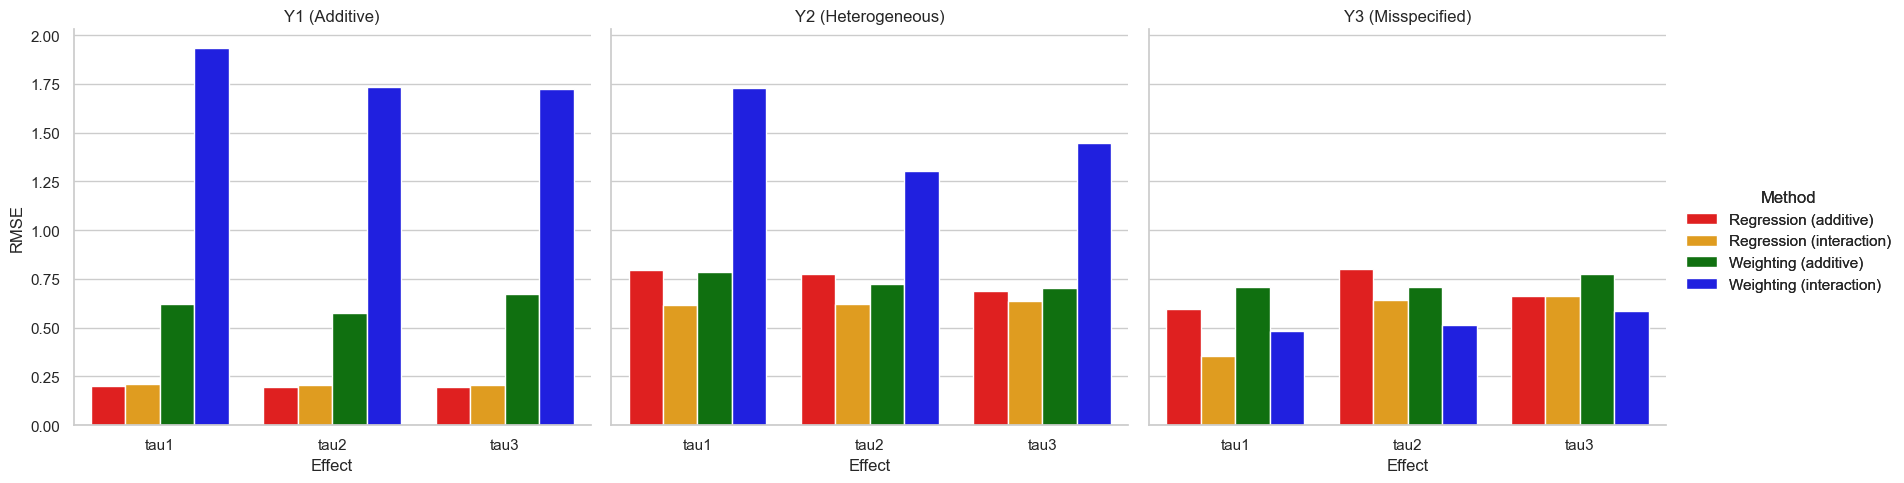

In [23]:
def plot_rmse_comparison(results_dict):
    """
    Creates a grouped bar chart comparing RMSE values across different estimation methods
    and outcome models (Additive, Heterogeneous, Misspecified).
    
    Parameters:
    - results_dict: A dictionary where each key is a model type ('additive', 'het', 'mis'),
      and each value is another dictionary containing RMSE values for each method.
    
    Example structure:
    results_dict = {
        "additive": {
            "Regression (additive)": [0.05, 0.1, 0.08],
            "Regression (interaction)": [0.2, 0.25, 0.22],
            "Weighting (additive)": [0.12, 0.14, 0.15],
            "Weighting (interaction)": [0.1, 0.12, 0.09]
        },
        "het": { ... },
        "mis": { ... }
    }
    """

    effects = ['tau1', 'tau2', 'tau3']
    models = {"additive": "Y1 (Additive)", "het": "Y2 (Heterogeneous)", "mis": "Y3 (Misspecified)"}
    
    # Convert dictionary into DataFrame for plotting
    data = []
    for model_type, rmse_vals in results_dict.items():
        for method, values in rmse_vals.items():
            for i, val in enumerate(values):
                data.append([models[model_type], effects[i], val, method])

    df = pd.DataFrame(data, columns=["Outcome Model", "Effect", "RMSE", "Method"])
    
    # Set style
    sns.set(style="whitegrid")

    # Create FacetGrid bar plot
    g = sns.catplot(
        data=df,
        x="Effect",
        y="RMSE",
        hue="Method",
        col="Outcome Model",
        kind="bar",
        palette=['red', 'orange', 'green', 'blue'],
        height=5,
        aspect=1
    )

    # Adjust labels
    g.set_axis_labels("Effect", "RMSE")
    g.set_titles("{col_name}")
    g.set_xticklabels(rotation=0)
    g.add_legend(title="Method")

    # Show the plot
    plt.show()

# Example usage with dummy data (Replace this with actual simulation results)
results_dict = {
    "additive": {
        "Regression (additive)": [0.20292603, 0.19599354, 0.19467241],
        "Regression (interaction)": [0.21123689, 0.20836276, 0.20720798],
        "Weighting (additive)": [0.62020931, 0.57634086, 0.67050514],
        "Weighting (interaction)": [1.93253405, 1.7337093, 1.72272062]
    },
    "het": {
        "Regression (additive)": [0.79780011, 0.77323037, 0.69033354],
        "Regression (interaction)": [0.6163207, 0.62022501, 0.63472543],
        "Weighting (additive)": [0.7876455, 0.72261962, 0.70493817],
        "Weighting (interaction)": [1.72937341, 1.30554973, 1.44615926]
    },
    "mis": {
        "Regression (additive)": [0.59488916, 0.80096286, 0.66287507],
        "Regression (interaction)": [0.35662495, 0.6409795, 0.66334748],
        "Weighting (additive)": [0.7062832, 0.70904473, 0.77405944],
        "Weighting (interaction)": [0.48402497, 0.51469488, 0.5853537]
    }
}

plot_rmse_comparison(results_dict)